<a href="https://colab.research.google.com/github/zackives/upenn-cis-2450/blob/main/CIS_2450_Lab_8_Linear_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 8: Linear Models (Fall 2024)

**Date:** Thursday Nov 7
<br>
**Lab TAs:** `Binbin Chen` and `Vivian Xiao`

Machine learning algorithms can be a powerful tool for classifying data using machine language. In this lab, we'll discuss linear models, including linear/logistic regression and classification as well as a crash course on using train_test_split, hyperparameter tuning, and analyzing model accuracy.

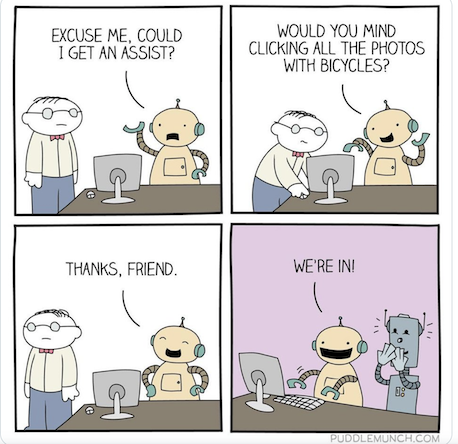

# Introduction to Supervised Learning

Supervised Learning involves training a model to make predictions. This means the model is trained using both a set of many **features** (the $\textbf{X}$) as well as a **target variable** (the $\vec{\textbf{y}}$, which is the "answer" we want to predict).

## Two Types of Supervised Learning: Regression vs. Classification

**Regression:** the target variable is within a _continuous_ range.
  - e.g. price, crop yield, etc.

**Classification:** the target variable is _categorical_.
1. _Binary Classification_ **[Our Focus]**: there are exactly 2 outcomes, typically labeled as $\{0,1\}$ or as $\{-1,+1\}$
  - e.g. churn/no churn, cancer/no cancer, yes/no, etc.
2. _Multi-Class Classification_: there are 3 or more outcomes
  - e.g. type of animal, etc.

# Setup Jargon

## Libraries and Other Jargon

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns; sns.set()

from struct import unpack
import json
from datetime import datetime
from collections import Counter
import glob
import re
import os

import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
!wget -nc https://storage.googleapis.com/penn-cis545/combined_anime.csv -O anime.csv

File ‘anime.csv’ already there; not retrieving.


## Dataset Cleaning and Preparation

This is **NOT** the focus of our recitation, so we've gone ahead and cleaned this data for you. Just run these cells for the purpose of our recitation.

If you want, feel free to come back here in your own time after the recitation to understand what cleaning tasks have been done. These may be quite similar to the EDA tasks you have to do in HW4!

In [ ]:
# Read original/raw data
anime_df = pd.read_csv('/content/anime.csv')

In [ ]:
# NO need to edit
# Dropping nulls and extra leftmost column
anime_df = anime_df.dropna(subset = {'anime_id', 'genre'})
anime_df = anime_df.drop(columns = ['Unnamed: 0'])

# Explode genre
anime_df['genre'] = anime_df['genre'].str.strip()
anime_df['genre'] = anime_df['genre'].str.split(',')
anime_df = anime_df.explode('genre')

# Take subset of anime_df as specified
desired_columns = ['anime_id', 'username', 'title', 'score',
                   'scored_by', 'rank', 'popularity', 'members',
                   'source', 'favorites', 'studio', 'genre']
new_anime_df = anime_df.loc[:, desired_columns]
new_anime_df = new_anime_df.dropna()
new_anime_df

# Label Encoding
from sklearn.preprocessing import LabelEncoder
le_genre = LabelEncoder()
le_genre.fit(new_anime_df['genre'])
le_studio = LabelEncoder()
le_studio.fit(new_anime_df['studio'])
le_source = LabelEncoder()
le_source.fit(new_anime_df['source'])
le_title = LabelEncoder()
le_title.fit(new_anime_df['title'])

# Add as columns to new_anime_df
new_anime_df['genre_labels'] = le_genre.transform(new_anime_df['genre'])
new_anime_df['studio_labels'] = le_studio.transform(new_anime_df['studio'])
new_anime_df['source_labels'] = le_source.transform(new_anime_df['source'])
new_anime_df['title_labels'] = le_title.transform(new_anime_df['title'])

# Create classification target variable (whether score is > mean)
mean_score = anime_df['score'].mean()
new_anime_df['above_average'] = np.where(new_anime_df['score'] > mean_score, 1.0, 0.0)

# Export cleaned file to be used later in SparkML
new_anime_df.to_csv('/content/combined_anime.csv')

#### 💡 **Discussion Point** 💡
Let's take a look at our cleaned dataframe.
1. What kind of information does the `new_anime_df` dataset here contain?
2. Do you think it makes sense to _readily_ use all the columns of this dataframe as it is to build a classification model? What problems do you foresee?

In [ ]:
new_anime_df = pd.read_csv('/content/combined_anime.csv')

In [ ]:
# Peek
new_anime_df.head()

,Unnamed: 0,anime_id,username,title,score,scored_by,rank,popularity,members,source,favorites,studio,genre,genre_labels,studio_labels,source_labels,title_labels,above_average
0,0,10020,Zukin-Man,Ore no Imouto ga Konnani Kawaii Wake ga Nai Sp...,7.57,83849,1435.0,658,127176,Light novel,176,AIC Build,Slice of Life,69,14,5,3724,0.0
1,0,10020,Zukin-Man,Ore no Imouto ga Konnani Kawaii Wake ga Nai Sp...,7.57,83849,1435.0,658,127176,Light novel,176,AIC Build,Comedy,2,14,5,3724,0.0
2,1,19111,AluPachi,Love Live! School Idol Project 2nd Season,7.99,79740,570.0,599,138715,Other,2475,Sunrise,Music,57,480,10,2864,1.0
3,1,19111,AluPachi,Love Live! School Idol Project 2nd Season,7.99,79740,570.0,599,138715,Other,2475,Sunrise,School,25,480,10,2864,1.0
4,1,19111,AluPachi,Love Live! School Idol Project 2nd Season,7.99,79740,570.0,599,138715,Other,2475,Sunrise,Slice of Life,32,480,10,2864,1.0


In [ ]:
cleaned_anime_df = new_anime_df.drop_duplicates(subset=['genre','studio','source','title','scored_by', 'popularity', 'favorites'])

In [ ]:
cleaned_anime_df.head(3)

,Unnamed: 0,anime_id,username,title,score,scored_by,rank,popularity,members,source,favorites,studio,genre,genre_labels,studio_labels,source_labels,title_labels,above_average
0,0,10020,Zukin-Man,Ore no Imouto ga Konnani Kawaii Wake ga Nai Sp...,7.57,83849,1435.0,658,127176,Light novel,176,AIC Build,Slice of Life,69,14,5,3724,0.0
1,0,10020,Zukin-Man,Ore no Imouto ga Konnani Kawaii Wake ga Nai Sp...,7.57,83849,1435.0,658,127176,Light novel,176,AIC Build,Comedy,2,14,5,3724,0.0
2,1,19111,AluPachi,Love Live! School Idol Project 2nd Season,7.99,79740,570.0,599,138715,Other,2475,Sunrise,Music,57,480,10,2864,1.0


In [ ]:
len(new_anime_df), len(new_anime_df\
                       .drop_duplicates(subset=['genre','studio','source','title',
                                                'scored_by', 'popularity', 'favorites']))

(1386393, 21460)

# Data Preprocessing: Clarifications about Standardization and Train-Test Splits

## 1. Constructing our feature dataframes ($\textbf{X}$) and label vector ($\vec{\textbf{y}}$)

In [ ]:
catgorical = ['genre', 'studio', 'source', 'title']
numerical = ['scored_by', 'popularity', 'favorites']

In [ ]:
# peek
for col in catgorical:
  print(col, Counter(cleaned_anime_df[col]).most_common()[:10])

genre [('Action', 1931), (' Comedy', 1439), ('Comedy', 1214), (' Fantasy', 1182), (' Shounen', 1114), (' Romance', 1059), (' Sci-Fi', 1024), (' Drama', 1004), (' School', 929), (' Supernatural', 801)]
studio [('Toei Animation', 1527), ('Sunrise', 1148), ('Madhouse', 997), ('J.C.Staff', 844), ('Studio Deen', 828), ('Studio Pierrot', 768), ('Production I.G', 625), ('TMS Entertainment', 574), ('A-1 Pictures', 553), ('OLM', 502)]
source [('Manga', 9396), ('Original', 5218), ('Light novel', 2059), ('Game', 1355), ('Visual novel', 992), ('Novel', 829), ('4-koma manga', 540), ('Other', 367), ('Web manga', 305), ('Card game', 131)]
title [('Ani*Kuri15', 13), ('Nihon Animator Mihonichi', 11), ('Asagiri no Miko', 11), ('Trinity Seven', 10), ('Kenpuu Denki Berserk', 10), ('InuYasha: Kanketsu-hen', 10), ('Berserk 2nd Season', 10), ('InuYasha', 10), ('Trinity Seven: Nanatsu no Taizai to Nana Madoushi', 10), ('Berserk', 10)]


In [ ]:
# consider the top 20 most popular values
for col in catgorical:
  keep_set = dict(Counter(cleaned_anime_df[col]).most_common()[:20]).keys()
  cleaned_anime_df[col] = cleaned_anime_df[col].apply(lambda x: x if x in keep_set else "Unknown")

In [ ]:
# create dummy varible for categorical columns
dummy_df = pd.get_dummies(cleaned_anime_df[catgorical])
dummy_df.shape

(21460, 78)

In [ ]:
dummy_df.head(2)

,genre_ Adventure,genre_ Comedy,genre_ Drama,genre_ Ecchi,genre_ Fantasy,genre_ Magic,genre_ Mecha,genre_ Romance,genre_ School,genre_ Sci-Fi,...,title_Kenpuu Denki Berserk,title_Macross 7,title_Mahou Sensei Negima!,title_Nihon Animator Mihonichi,title_Saber Marionette J,title_Trinity Seven,title_Trinity Seven: Nanatsu no Taizai to Nana Madoushi,title_Unknown,title_Zero no Tsukaima,title_Zero no Tsukaima: Princesses no Rondo
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [ ]:
# features: feature dataframe, or "design matrix", or simply X - include the numeric cols and dummies
features = pd.concat([cleaned_anime_df[numerical], dummy_df], axis = 1)

# labels: our label vector, or target variable, or simply y
labels = cleaned_anime_df['above_average']

In [ ]:
# Implied columns that were dropped from the df to create the feature matrix
set(new_anime_df) - set(features)

{'Unnamed: 0',
 'above_average',
 'anime_id',
 'genre',
 'genre_labels',
 'members',
 'rank',
 'score',
 'source',
 'source_labels',
 'studio',
 'studio_labels',
 'title',
 'title_labels',
 'username'}

## 2. Split Data into Train and Test

**Rationale**
- _The Issue:_ data is scarce...yet we still need to build a model that generalizes well beyond our dataset. How then would we assess the generalizability of our model if we use the entire dataset to train it?
- _The Workaround:_ we want to **_train_** our model on a major portion of the data, but save a portion of the data so that it is "unseen" by our model so that we can **_test_** how well it does with unfamiliar data points.

**Quick Primer: Overfitting and Underfitting**
- By having training and testing sets, we can evaluate/score them independently then make a judgment about how good our model is.
  - _Underfit:_ model performs poorly on both familiar data (training) and unfamiliar/unseen data (testing)
  - _Overfit:_ model performs well on familiar data (training) but not as well on unfamiliar/unseen data (testing). This suggests that our model became too acclimated to what it was trained with and cannot generalize well.

**Implementation**

Use scikit-learn's `train_test_split` function and split data into train and test sets. We're choosing to do an 80/20 split, meaning 80% for training and the remaining 20% for testing.

To make results reproduceable, **set the random_state parameter = 42** and store the resulting splits as `x_train`, `x_test`, `y_train`, and `y_test`.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state = 42, test_size = 0.2)

In [ ]:
x_train.shape, x_test.shape

((17168, 81), (4292, 81))

## 3. Creating scaled versions of the feature dataframe

From the Unsupervised Learning module, you already saw examples of models that are _NOT_ scale-invariant and therefore need to be fed features that have been standardized.

Likewise, there are certain Supervised Learning models that require standardization for the same reason.

## Best Practices

We want to **standardize** `x_train` and `x_test` to have zero mean and unit variance using `x_train`'s mean and standard deviation. That's why we must instantiate a `StandardScaler()` object, then `.fit_transform()` on `x_train` but only need to transform on `x_test` using the same `StandardScaler()` object we just created.

The reason neither the scaler nor the PCA are fit again on `x_test` is because your machine learning models are trained on `x_train`. This way, when you later use these models to predict on `x_test`, the `x_test` variables will be scaled accordingly to the model's `x_train` specifications.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Instantiate object
scaler = StandardScaler()

# Learn mean and SD from training set, then standardize training set
x_train_sc = scaler.fit_transform(x_train)

# Use learned mean and SD to standardize testing set
x_test_sc = scaler.transform(x_test)

# Linear Regression

Linear Regression models are of the form:

$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p$$

where the weights ($\beta_j$) are estimated by solving a very particular optimization problem _(minimizing the sum of squared errors)_.

Our goal is to find the optimal values for the weights, **w**, in a linear function that best fit the data. Specifically, we want to find **w** values that minimize the difference between the predicted values $\widehat{y}$
and the actual values $y$.

To achieve this, we aim to minimize the **Root Mean Square Error (RMSE)**, which represents the standard deviation of the residuals:

<p align="center">
  <img src="https://latex.codecogs.com/gif.latex?\dpi{150}&space;\text{RMSE}(X,&space;w,&space;y)&space;=&space;\sqrt{\&space;\frac{1}{n}&space;\sum_{i=1}^{n}&space;(x_i&space;\cdot&space;w&space;-&space;y_i)^2&space;}" width="300" height="60" />
</p>

However, it is more common to minimize the **Mean Squared Error (MSE)**, as it is easier to work with mathematically. The MSE is given by:

$$
\text{MSE}(X, w, y) = \frac{1}{n} \sum_{i=1}^{n} (x_i \cdot w - y_i)^2
$$

### Concept of Minimizing MSE

The Mean Squared Error (MSE) measures the average squared difference between the predicted values and the actual values. By minimizing this error, we ensure that the model’s predictions are as close as possible to the true values, on average. In linear regression, this is achieved by finding the **weights (w)** that minimize the MSE. This optimization process leads to the best-fit line, which minimizes the overall prediction error for the dataset.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [ ]:
# Instantiate regular (unregularized) Linear Regression
linreg = LinearRegression()

# Fit to scaled data
linreg.fit(x_train_sc, y_train)

# Predict on training and testing sets
train_pred = linreg.predict(x_train_sc)
test_pred = linreg.predict(x_test_sc)

In [ ]:
# Get Training R^2 (measures variance)
linreg.score(x_train_sc, y_train)

0.27342498935435244

In [ ]:
# Get Testing R^2
linreg.score(x_test_sc, y_test)

0.2743712761490651

In [ ]:
# Get Training Mean Squared Error (MSE)
mean_squared_error(y_train, train_pred)

0.13599974812510615

In [ ]:
# Get Testing MSE
mean_squared_error(y_test, test_pred)

0.13664518449385119

The model explains about 27% of the variance in the target variable on both training and testing data. This is a relatively low $R^2$, suggesting that the model doesn’t explain much of the variance, meaning it might be underfitting.

The MSE values are similar for both training and testing, indicating that the model generalizes reasonably well but still has a significant error.

## Ridge (L2) Regression

**Ridge regression**, also known as L2 regularization, helps to prevent overfitting by adding a penalty term to the traditional linear regression loss function. This penalty term is controlled by a hyperparameter \( \lambda_2 \), which determines the strength of the regularization.

1. **Objective**: Ridge regression **shrinks the weights** to prevent them from becoming too large, which can help in cases of multicollinearity (where predictor variables are highly correlated) and overfitting (where the model fits the training data too closely).

2. **L2 Penalty**: Ridge regression adds a penalty equal to the **squared L2 norm** of the weights (i.e., the sum of the squared values of the coefficients). This penalty grows **quadratically** with the size of the weights.

   - The L2 penalty term is represented as:
     $
     \lambda_2 \|\mathbf{w}\|_2^2
     $
   - Here, $ \|\mathbf{w}\|_2^2 $ is the sum of the squares of the weights, and $\lambda_2$ controls the penalty's strength.

3. **Minimizing the Objective Function**: In Ridge regression, we aim to minimize the **Mean Squared Error (MSE)** of the model plus the penalty:

   $$
   \frac{1}{n} \sum_{i=1}^{n} (x_i \cdot \mathbf{w} - y_i)^2 + \lambda_2 \|\mathbf{w}\|_2^2
   $$

   - The first term, $\frac{1}{n} \sum_{i=1}^{n} (x_i \cdot \mathbf{w} - y_i)^2$, is the **MSE** and measures the model's error.
   - The second term, $\lambda_2 \|\mathbf{w}\|_2^2$, is the **regularization penalty**, which discourages large weights.

### Key Takeaways
- **Larger $\lambda_2$**: Increases the regularization effect, further shrinking the weights and reducing model complexity.
- **Smaller $\lambda_2$**: Reduces the regularization effect, making Ridge regression closer to regular linear regression.
- **Trade-off**: By tuning $\lambda_2$, we balance between fitting the data well and keeping the model simple to prevent overfitting.

In summary, Ridge regression helps to create a more robust model by adding a small penalty for large coefficients, thereby improving the model's ability to generalize to new data.

In [ ]:
# Instantiate L2-Regularized (Ridge) Linear Regression (slide #_ in Linear and Logistic Regression lecture)
linreg_ridge = Ridge(alpha=0.1) # λ in the above equations corresponds to alpha here

# Fit to scaled data (why?)
linreg_ridge.fit(x_train_sc, y_train)

# Predict on training and testing sets
train_pred_l2 = linreg_ridge.predict(x_train_sc)
test_pred_l2 = linreg_ridge.predict(x_test_sc)

In [ ]:
# Get Training R^2 (measures variance)
linreg_ridge.score(x_train_sc, y_train)

0.27910310292929974

In [ ]:
# Get Testing R^2
linreg_ridge.score(x_test_sc, y_test)

0.2816904940529993

In [ ]:
# Get Training Mean Squared Error (MSE)
mean_squared_error(y_train, train_pred_l2)

0.1349369232209956

In [ ]:
# Get Testing MSE
mean_squared_error(y_test, test_pred_l2)

0.13526688199842896

Adding a small amount of L2 regularization improved the $R^2$ slightly, which indicates that the model might benefit from some regularization.

The training and testing MSE values are also slightly lower than in the unregularized model, suggesting that Ridge regularization with 𝛼 =0.5 reduces the model's error without overfitting.

This model performs slightly better than unregularized linear regression, indicating that Ridge regression may be a better choice for this dataset.

## Lasso (L1) Regression

**Lasso regression**, also known as L1 regularization, adds a penalty based on the **L1 norm** (the sum of the absolute values of the weights) to the linear regression objective. This penalty encourages sparsity in the model, effectively setting some weights to zero.

1. **L1 Penalty**: Lasso regression penalizes the model based on the absolute values of the weights, pushing less important weights towards zero.

   - The L1 penalty term is represented as:
     $
     \lambda_1 \|\mathbf{w}\|_1
     $
   - Here, $\|\mathbf{w}\|_1$ is the sum of the absolute values of the weights, and $\lambda_1$ controls the strength of the penalty.

2. **Sparsity**: By driving some weights to zero, Lasso regression can automatically perform **feature selection**. This results in a "sparser" model, where only the most relevant features are kept, making the model more interpretable and potentially more robust.

3. **Objective Function**: In Lasso regression, we aim to minimize the **Mean Squared Error (MSE)** of the model along with the L1 penalty:

   $$
   \frac{1}{n} \sum_{i=1}^{n} (x_i \cdot \mathbf{w} - y_i)^2 + \lambda_1 \|\mathbf{w}\|_1
   $$

   - The first term, $\frac{1}{n} \sum_{i=1}^{n} (x_i \cdot \mathbf{w} - y_i)^2$, is the **MSE** and measures the model's error.
   - The second term, $\lambda_1 \|\mathbf{w}\|_1$, is the **regularization penalty**, encouraging smaller weights.

### Key Takeaways
- **Larger $\lambda_1$**: Increases the regularization effect, leading to more weights being driven to zero and a sparser model.
- **Smaller $\lambda_1$**: Reduces the regularization effect, making Lasso regression closer to standard linear regression.
- **Feature Selection**: By setting some weights to zero, Lasso regression can effectively remove unimportant features from the model, which can be useful for high-dimensional data.

In summary, Lasso regression helps to simplify the model by encouraging sparsity, making it more interpretable and potentially more robust, especially in situations with many features or multicollinearity.

In [ ]:
# Instantiate L1-Regularized (Lasso) Linear Regression (slide #86 in Linear and Logistic Regression lecture)
linreg_lasso = Lasso(alpha=0.01)

# Fit to scaled data (why?)
linreg_lasso.fit(x_train_sc, y_train)

# Predict on training and testing sets
train_pred_l1 = linreg_lasso.predict(x_train_sc)
test_pred_l1 = linreg_lasso.predict(x_test_sc)

In [ ]:
# Get Training R^2
linreg_lasso.score(x_train_sc, y_train)

0.25881930051119706

In [ ]:
# Get Testing R^2
linreg_lasso.score(x_test_sc, y_test)

0.26545283622755733

In [ ]:
# Get Training MSE
mean_squared_error(y_train, train_pred_l1)

0.1387336296579952

In [ ]:
# Get Testing MSE
mean_squared_error(y_test, test_pred_l1)

0.13832464098229377

Even a small amount of L1 regularization causes the model $R^2$ to decrease and MSE to increase, corroborating our earlier insights that linear models may actually be underfitting on this dataset (while regularization generally helps with overfitting instead).

# Logistic Regression

Despite being called "regression", this is actually a classification model.

#### 💡 **Discussion Point** 💡

Why can't we use linear regression to tackle a classification problem ($y \in \{0,1\}$)?

**Logistic Regression Equation**

We need a way to "squash" the standard regression output to a range $[0,1]$: the logit function!

$$\ln\left(\frac{\text{Pr}(y = 1)}{1 - \text{Pr}(y = 1)}\right) = \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p$$

$$\implies \text{Pr}(y = 1) = \frac{e^{\beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p}}{1 + e^{\beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p}}$$

Like Linear Regression, these coefficients $\beta_j$ are estimated by solving an optimization problem (which we won't get into but you'll see in lecture and can dive deeper if you take CIS 520).

Using some rounding threshold (by default 0.5 unless changed), we predict $\hat{y} = 1$ if the estimated $\text{Pr}(y = 1) \ge 0.5$, and $\hat{y} = 0$ otherwise.

**Implementation**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Instantiate Default Logistic Regression as baseline model
logreg = LogisticRegression()

# Fit to scaled data
logreg.fit(x_train_sc, y_train)

# Predict on training and testing sets
train_pred = logreg.predict(x_train_sc)
test_pred = logreg.predict(x_test_sc)

In [ ]:
# Get Training Accuracy
logreg.score(x_train_sc, y_train)

0.8394687791239516

In [ ]:
# Get Testing Accuracy
logreg.score(x_test_sc, y_test)

0.8341099720410066

In [ ]:
# Instantiate Elasticnet(L1&L2)-Regularized Logistic Regression with more hyperparameter settings
logreg2 = LogisticRegression(solver = 'saga', penalty = "elasticnet", l1_ratio=0.8)

# Fit to scaled data
logreg2.fit(x_train_sc, y_train)

# Predict on training and testing sets
train_pred = logreg2.predict(x_train_sc)
test_pred = logreg2.predict(x_test_sc)

In [ ]:
# Get Training Accuracy
logreg2.score(x_train_sc, y_train)

0.8387115563839702

In [ ]:
# Get Testing Accuracy
logreg2.score(x_test_sc, y_test)

0.8303821062441752

# Hyperparameter Tuning

**What Are Hyperparameters?**

When a model is being trained on a data set, it determines the best parameters for each predictor variable. This can be seen in a linear regression, where the coefficients are determined for each variable used in the model. The coefficients in this case are the **parameters**: they are found via the training process. **Hyperparameters** on the other hand are parameters that are independent of the training process — we sets them beforehand.

In short:
*   Parameters are found by training the model
*   Hyperparameters are set by us before training

Since different set of hyperparameters can bring different model performance, usually we'd like to find a way to tune hyperparameters for better results.

### Hyperparameter tunning methods

**Process of Hyperparameter Tuning**

The process of hyperparameter tuning can be:

*   Obtaining a **baseline** with no hyperparameter tuning where we have a benchmark to improve
*   Exhaustively **grid searching** over a set of hyperparameters
*   Utilizing a **random search** to sample from a hyperparameter space

The two hyperparameter methods you’ll use most frequently with scikit-learn are a `grid search` and a `random search`.

#### Grid Search and Random Search

Grid search is where you pick x number of values that are evenly spaced along each axis (similar to our introductory example). This forms a grid — hence the name. Random search is when x-squared number of values are picked randomly. Both cases generate x-squared number of points. This can be visualized below (x=3). Imagine that the color of the background indicates how accurate that combination is. Let’s say white means that this certain point performs well, and blue means it doesn’t:

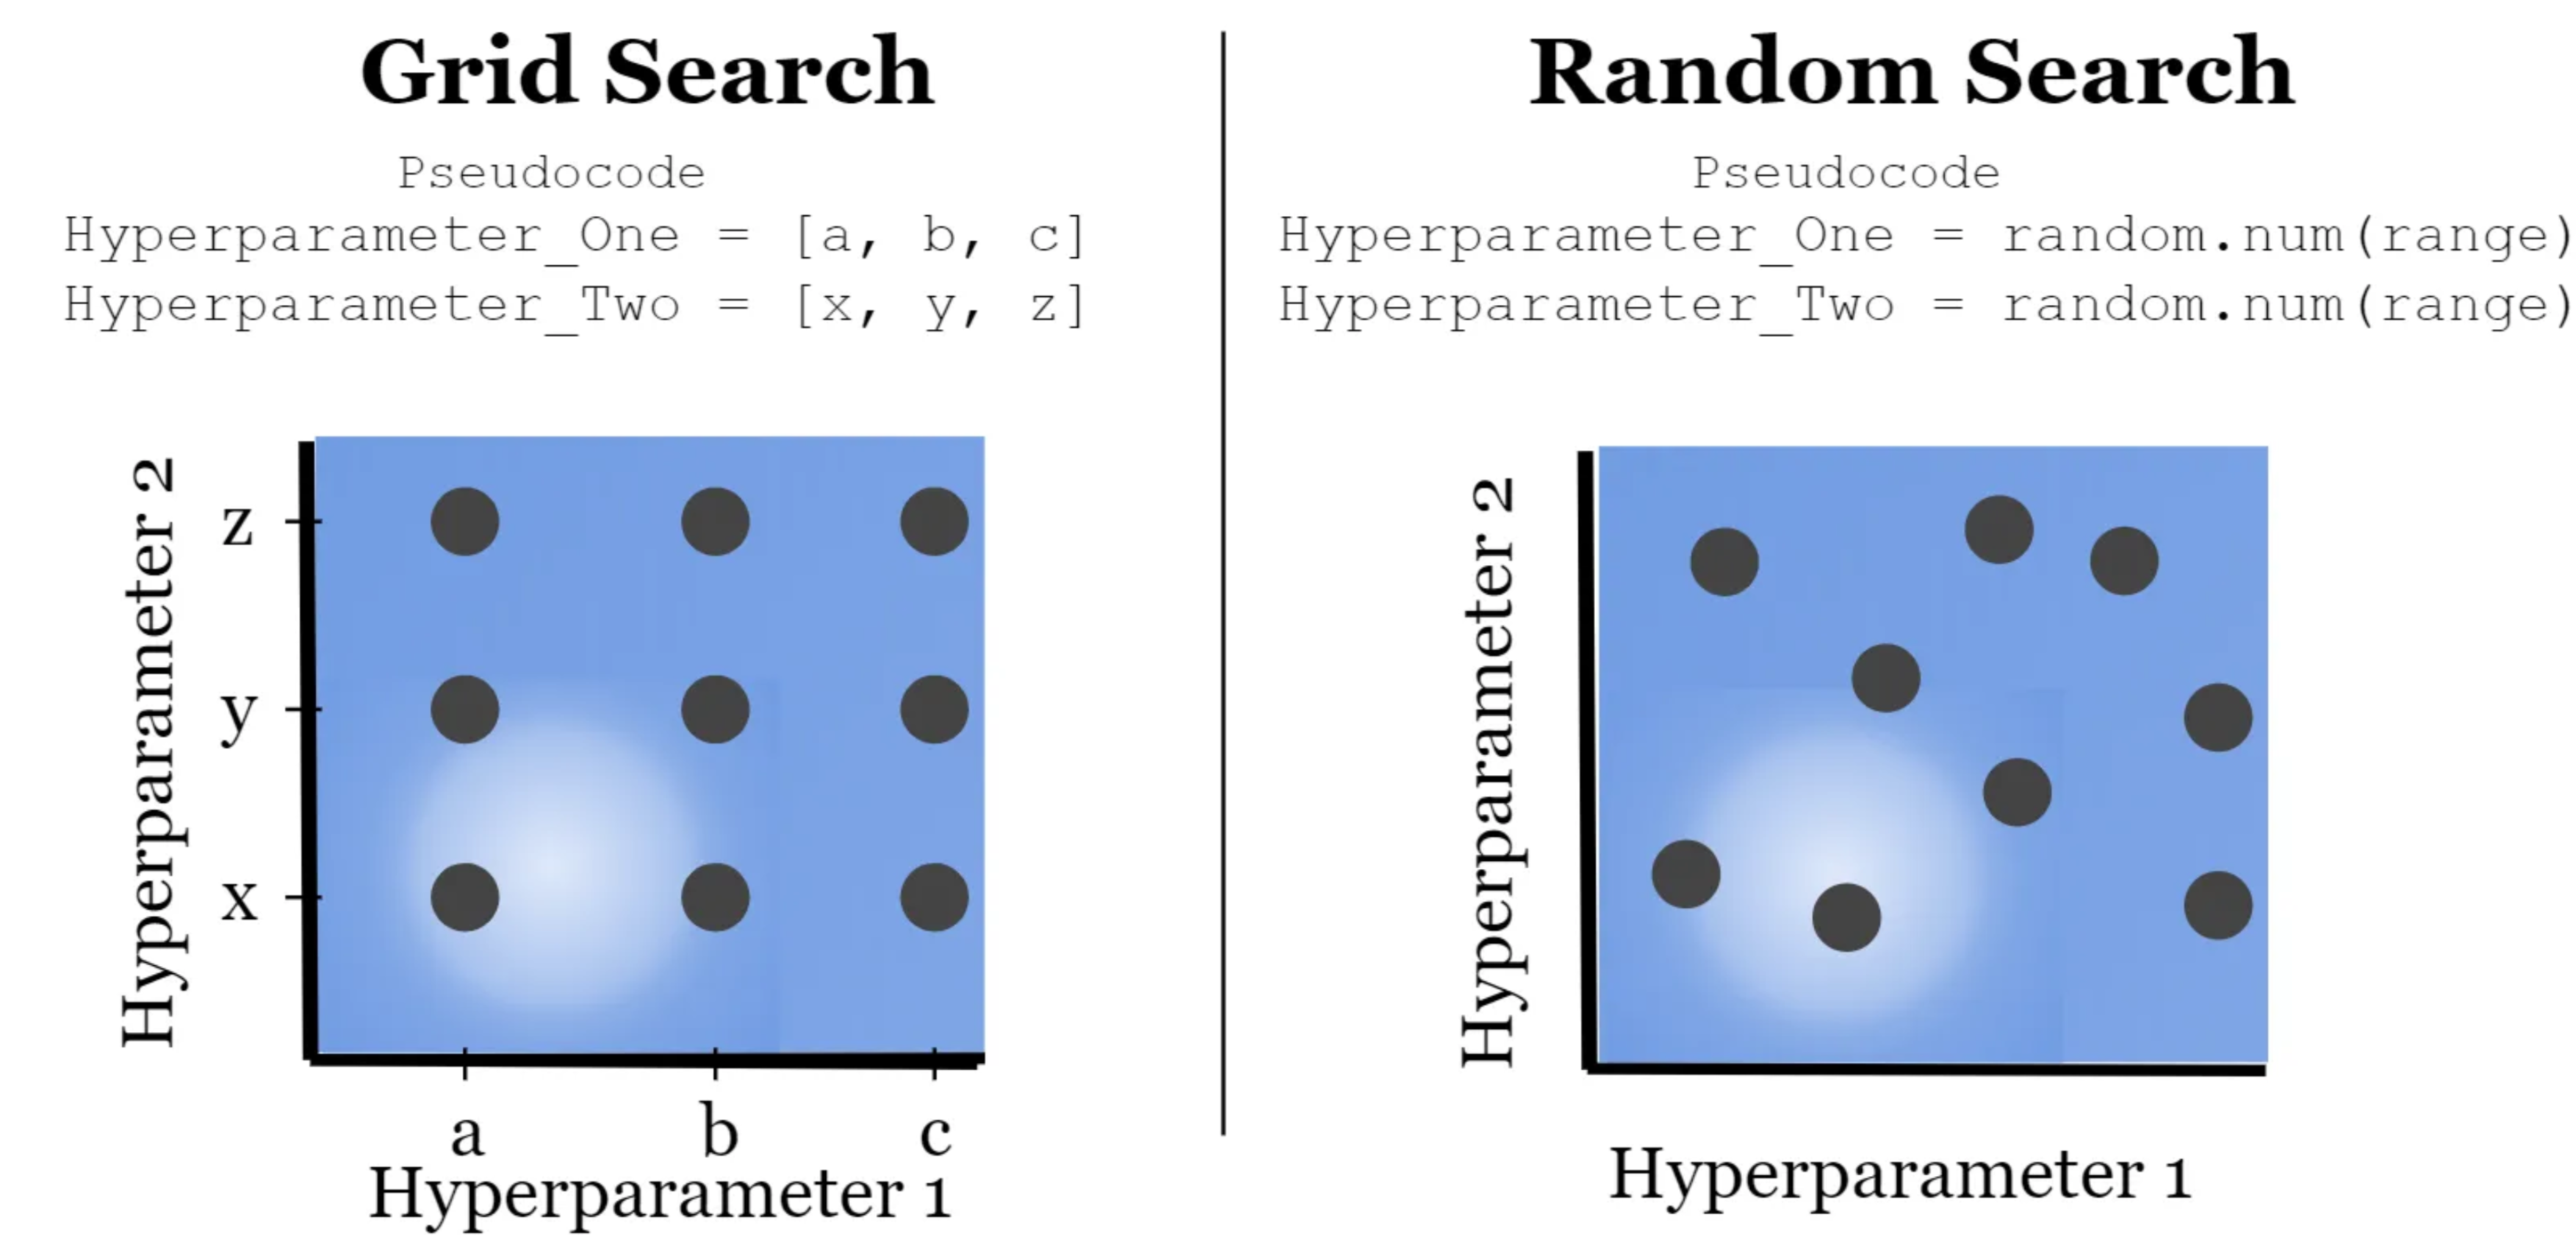

What if hyperparameter 1 is more important than hyperparameter 2? That means a small change in hyperparameter 1 is more important than a change in hyperparameter two. It’s like hyperparameter two doesn’t matter: as long as hyperparameter 1 is the right values the model will be accurate despite whatever value hyperparameter 2 is. This is shown below:

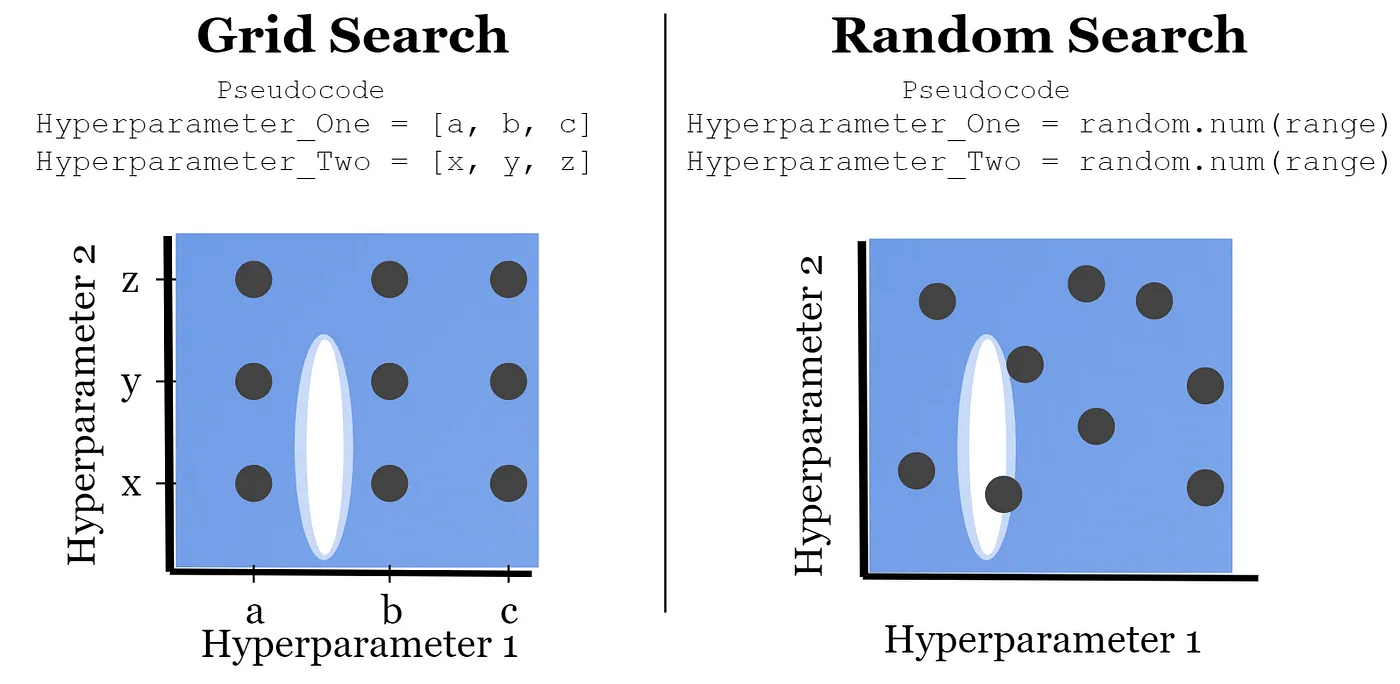

When tuning hyperparameters, there isn’t just one “golden set of values” that will give you the highest accuracy. Instead, it’s a distribution — there are ranges for each hyperparameter that will obtain the best accuracy. If you land within that range/distribution, you’ll still enjoy the same high accuracy without the requirement of exhaustively tuning your hyperparameters with a grid search.

#### Implementation in Logistic Regression

For this we will use a logistic regression which has many different hyperparameters (you can find a full list [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)). For this example we will only consider these hyperparameters:

*   The C value
*   The penalty (L1 or L2)
*   The type of solver used to train the logistic regression.



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [ ]:
C = np.logspace(0, 4, num=10)
penalty = ['l1', 'l2']
solver = ['liblinear', 'saga']

hyperparameters = dict(C=C, penalty=penalty, solver=solver)

In [ ]:
#Grid Search
logistic = LogisticRegression()
grid_search = GridSearchCV(logistic, hyperparameters)
best_model_grid = grid_search.fit(x_train_sc, y_train)
print(best_model_grid.best_estimator_)

LogisticRegression(C=1291.5496650148827, solver='liblinear')


In [ ]:
#Grid Search Tuned Model Performance
y_pred_grid = best_model_grid.predict(x_test_sc)
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89      3212
         1.0       0.78      0.47      0.58      1080

    accuracy                           0.83      4292
   macro avg       0.81      0.71      0.74      4292
weighted avg       0.83      0.83      0.82      4292



In [ ]:
#Random Search
randomized_search = RandomizedSearchCV(logistic, hyperparameters)
best_model_random = randomized_search.fit(x_train_sc, y_train)
print(best_model_random.best_estimator_)

LogisticRegression(C=10000.0, solver='liblinear')


In [ ]:
#Random Search Tuned Model Performance
y_pred_random = best_model_random.predict(x_test_sc)
print(classification_report(y_test, y_pred_random))

              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89      3212
         1.0       0.78      0.47      0.58      1080

    accuracy                           0.83      4292
   macro avg       0.81      0.71      0.74      4292
weighted avg       0.83      0.83      0.82      4292



# Interpreting Model Classification Performance

## Confusion Matrix
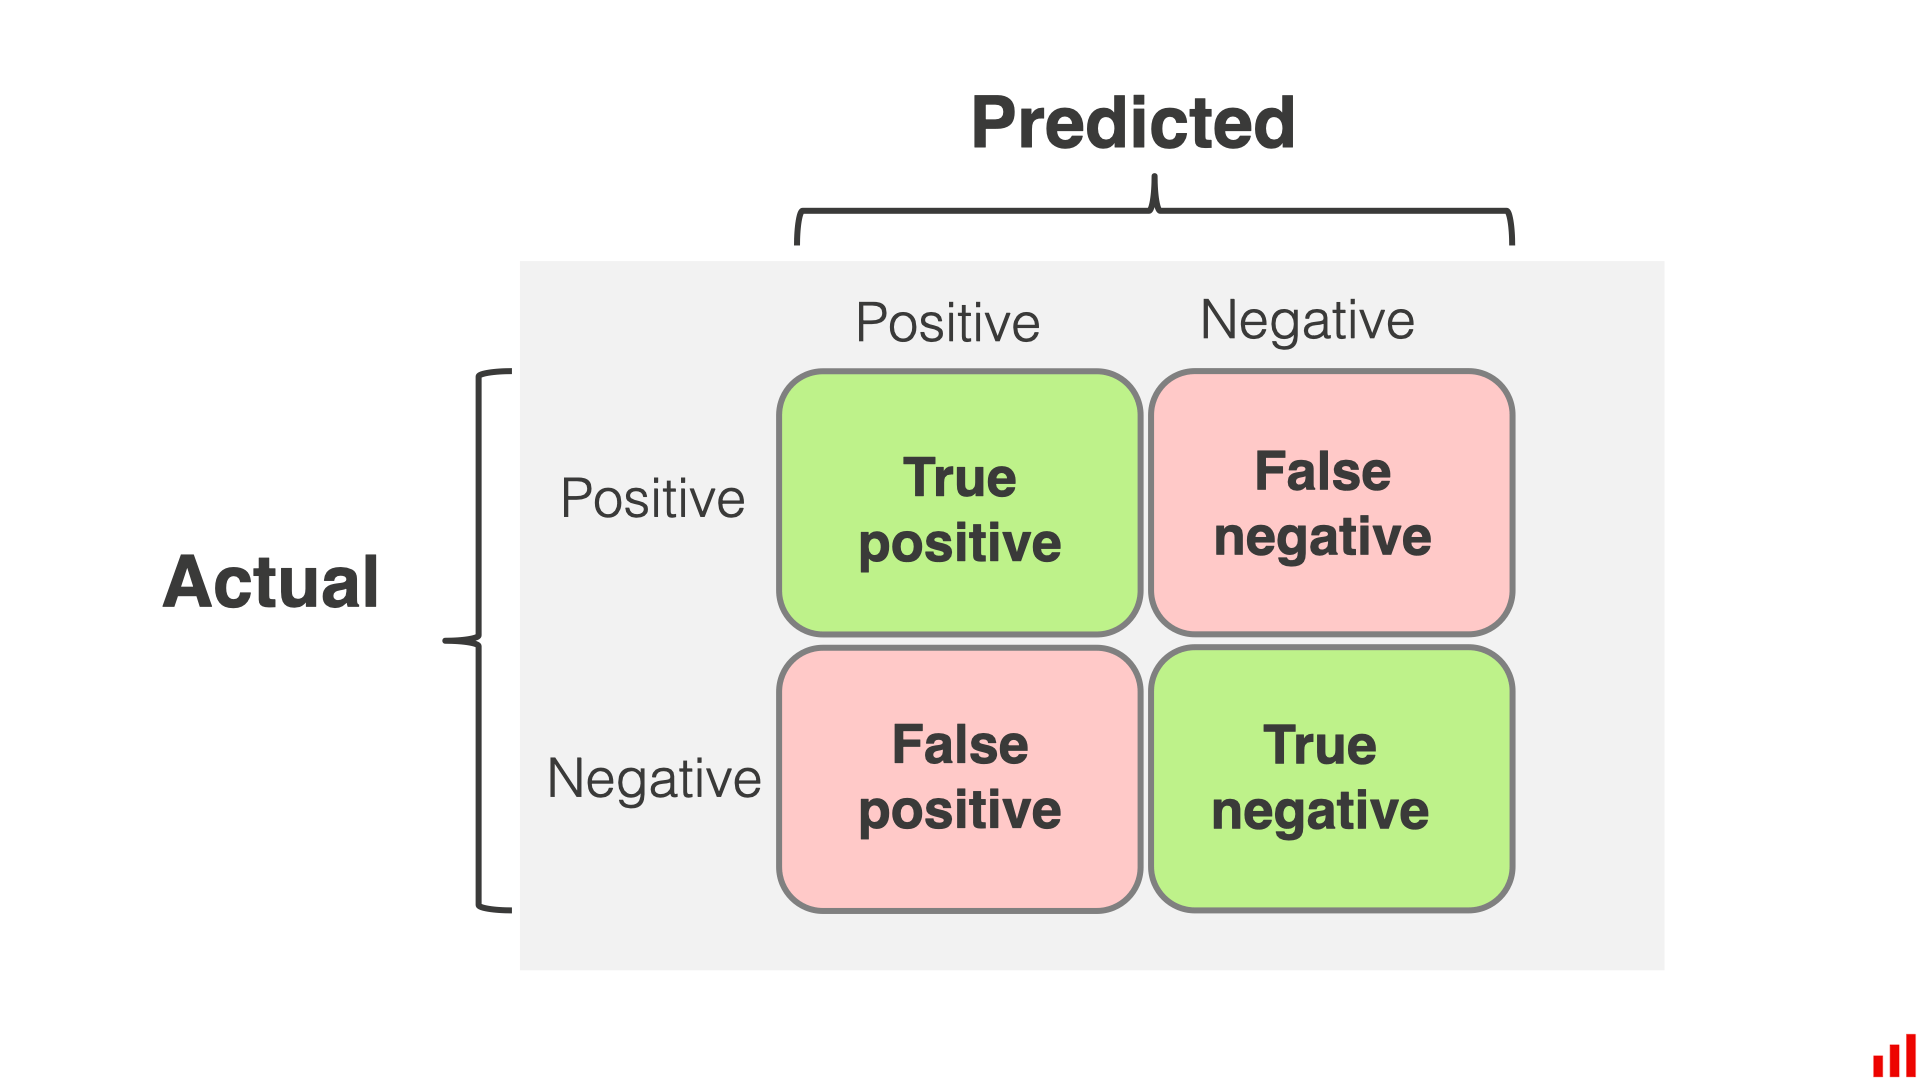



A confusion matrix is a useful tool for evaluating the performance of classification models in machine learning. It provides a summary of prediction results by displaying the counts of **true positive (TP)**, **false positive (FP)**, **true negative (TN)**, and **false negative (FN)** outcomes for each class.

*   **TP**: Correct predictions of positive class (model predicted positive, and it was indeed positive).
*   **TN**: Correct predictions of negative class (model predicted negative, and it was indeed negative).
* **FP**: Incorrect predictions of positive class (model predicted positive, but it was actually negative).
* **FN**: Incorrect predictions of negative class (model predicted negative, but it was actually positive).

From these values, you can calculate key metrics such as:

* **Accuracy**: The proportion of all correct predictions **(TP + TN)** over total predictions.
* **Precision**: The proportion of true positives out of all positive predictions **(TP / (TP + FP))**.
* **Recall (Sensitivity)**: The proportion of true positives out of all actual positives (TP / (TP + FN)).
* **F1 Score**: The harmonic mean of precision and recall, useful when you need a balance between the two.

Confusion matrices are commonly used to understand model performance on **unbalanced** datasets and to identify where models are making errors, such as when a model might be favoring one class over another. This matrix is great for binary classification problems, but it can also be extended to multi-class problems!

## Evaluation for Imbalanced Datasets

Classification accuracy is a metric that summarizes the performance of a classification model as the number of correct predictions divided by the total number of predictions.

Accuracy = Correct Predictions / Total Predictions

Achieving 90 percent classification accuracy, or even 99 percent classification accuracy, may be trivial on an imbalanced classification problem. Consider the case of an imbalanced dataset with a 1:100 class imbalance. Blind guess will give us a 99% accuracy score (by betting on majority class).

The rule of thumb is: accuracy never helps in imbalanced dataset.

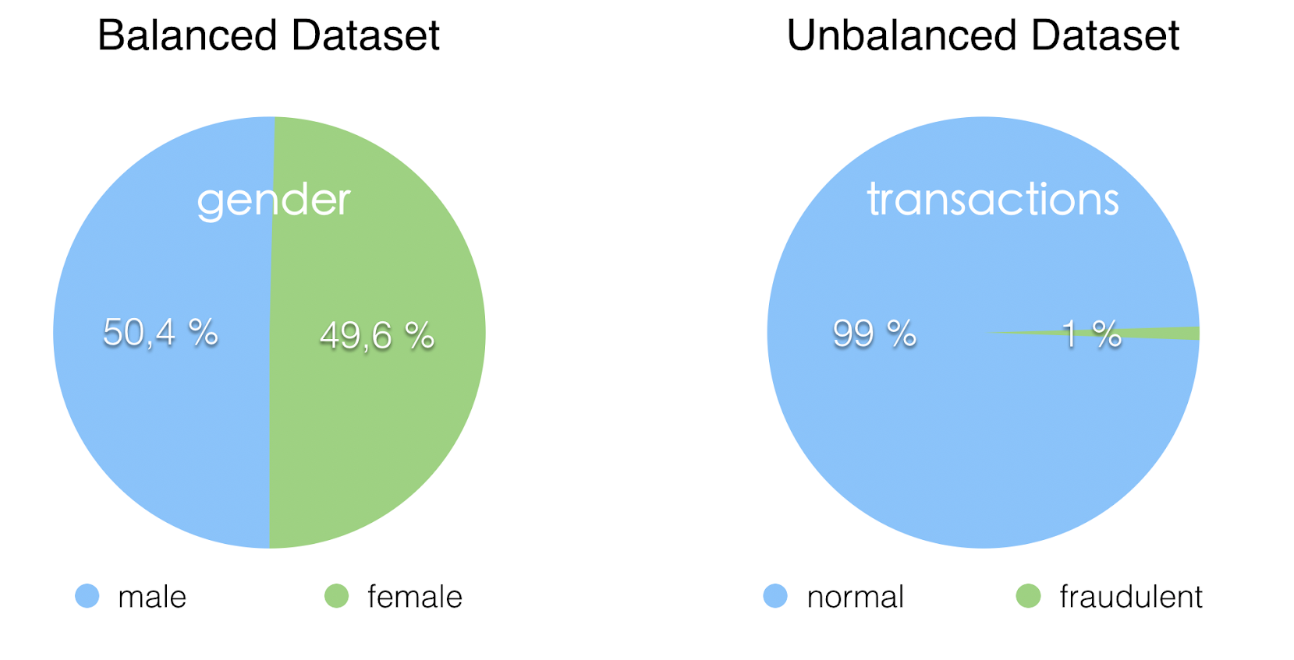

The most common metrics to use for imbalanced datasets are:

*   F1 score
*   Precision
* Recall
* AUC score (AUC ROC)
* Average precision score (AP)
* G-Mean

It is good practice to track multiple metrics when developing a machine learning model as each highlights different aspects of model performance.

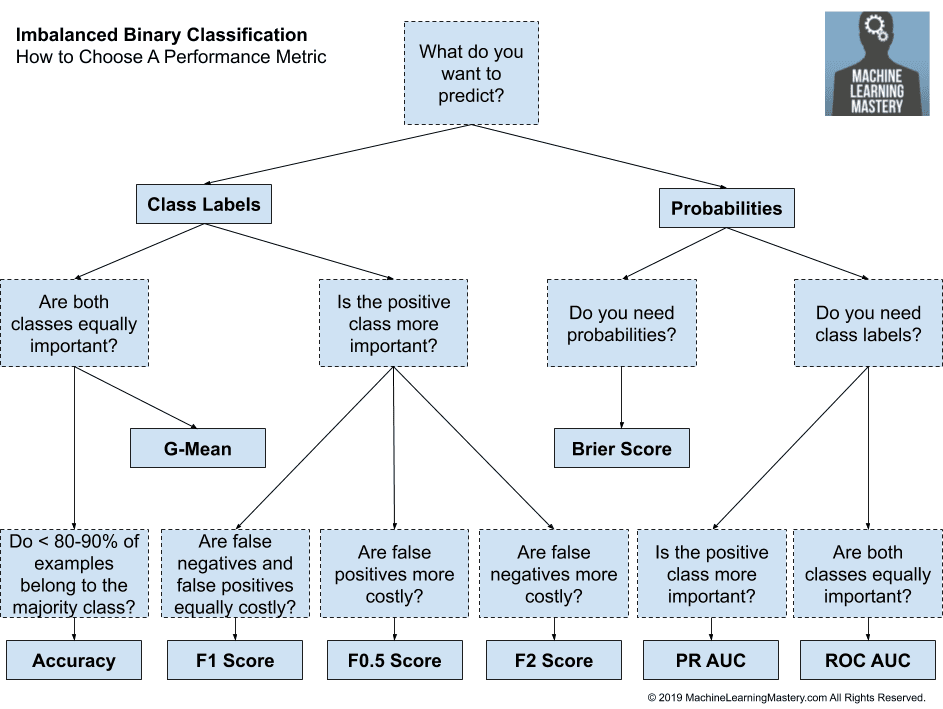